## Experiment 3: Realworld data & Multiple kernels & projections

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
from gp import *
import pandas as pd
import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")  # Apple Silicon
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


### Sunspots data

In [2]:
# Load CSV (skip comment lines if they exist)
df = pd.read_csv("data/SN_m_tot_V2.0.csv", sep=";", comment="#", header=None)

# According to the spec:
# Col 0 = Year, Col 1 = Month, Col 2 = Decimal year, Col 3 = Monthly mean
years = df[0].to_numpy()
months = df[1].to_numpy()
decimal_date = df[2].to_numpy()
sunspot_mean = df[3].to_numpy()

# Use fractional year directly as "date"
date_array = decimal_date  

number of training points: 3319


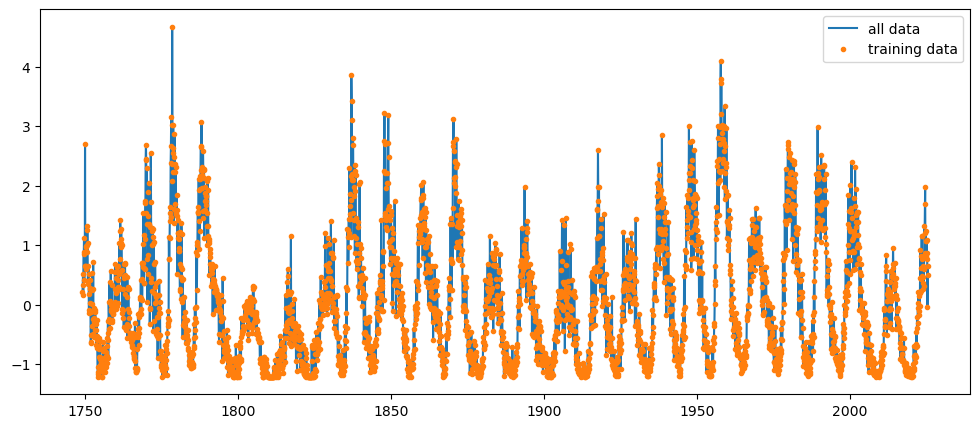

In [3]:
X_data = torch.from_numpy(date_array).unsqueeze(1)
y_data = torch.from_numpy(sunspot_mean).unsqueeze(1) 
# normalise
y_data = y_data - torch.mean(y_data)
y_std = torch.std(y_data)
if y_std > 0:     # guard against division by zero
    y_data = y_data / y_std

idx = torch.randperm(y_data.shape[0])[:]
# subset of the data
X_train = X_data[idx]
y_train = y_data[idx]

#X_train = X_data
#y_train = y_data

plt.figure(figsize=(12, 5))
plt.plot(X_data,y_data, label = 'all data')
plt.plot(X_train,y_train, '.', label = 'training data')
plt.legend()
print(f'number of training points: {y_train.shape[0]}')

In [4]:
## training preamble

kernels = ['SE', 'Laplace', 'RQ', 'LocPer']
methods = ['proj-sphere', 'proj-localised', 'proj-onehot', 'proj-mix'] #projections


M_elbo = 100
M_proj = 100

times_nll = []
out_nll = []





In [19]:
#training setting
methods = ['proj-sphere'] #projections

times_vfe = []
out_vfe = []
times_proj = []
out_proj = []

# for 1000 points
n_steps_1 = 2001
lr_1 = 0.5
tol = 1e-3
optimizer_1 = 'Adam'

# for 2000 points
n_steps_1 = 2001
lr_1 = 0.01
tol = 1e-3
optimizer_1 = 'Adam'

# for all 3300 points
n_steps_1 = 2001
lr_1 = 0.25
tol = 1e-3
optimizer_1 = 'Adam'

In [20]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = X_train.to(device)
X_train = X_train.to(device)


In [21]:
X_train.device

device(type='cpu')

In [22]:
## training routine



print('starting training ....')
for k in kernels:
    print(f'kernel = {k}')
    
    ##### Vanilla GP (NLL) #####
    print('NLL training ...')
    
    gp_nll = GP(X_train, y_train, kernel = k)
    out = gp_nll.train_step(obj = 'nll', opt_name=optimizer_1, lr=lr_1, n_steps=n_steps_1, tol=tol, verbose = True)

    
    times_nll.append(out["time"])     # save elapsed time
    out_nll.append(out["nll"])
    
    
    ##### SparseGP (ELBO) ##### 
    
    gp_elbo = GP(X_train, y_train, kernel = k, M=M_elbo, method = 'VFE')
    out = gp_elbo.train_step(obj = 'elbo', opt_name=optimizer_1, lr=lr_1, n_steps=n_steps_1, tol=tol, verbose = True)

    times_vfe.append(out["time"])     # save elapsed time
    out_vfe.append(out["nll"])
    
    for m in methods:
        print(f'projection method = {m}')
    
        ##### ProjGP ##### 
        gp_proj = GP(X_train, y_train, kernel = k, M=M_proj, method = m)
        out = gp_proj.train_step(obj = 'proj', opt_name=optimizer_1, lr=lr_1, n_steps=n_steps_1, tol=tol, verbose = True)        

        times_proj.append(out["time"])     # save elapsed time
        out_proj.append(out["nll"])
        
print('Training complete')        

starting training ....
kernel = SE
NLL training ...
Using device: cpu
Optimising nll using Adam
norma: tensor([1.0000, 1.0000, 0.6931], dtype=torch.float64, grad_fn=<CatBackward0>)
Epoch 0: loss = 3092.0322
Early stop at iteration 128: loss did not improve for 5 steps.
Elapsed time: 189.1[s] with NLL = 1549.12
Using device: cpu
[init_Z_kmeanspp] KMeans finished in 0.250 seconds
Optimising elbo using Adam
norma: tensor([1.0000, 1.0000, 0.6931], dtype=torch.float64, grad_fn=<CatBackward0>)
Epoch 0: loss = 4079.9920
Early stop at iteration 120: loss did not improve for 5 steps.
Elapsed time: 3.1[s] with NLL = 1692.07
projection method = proj-sphere
Using device: cpu
Optimising proj using Adam
norma: tensor([1.0000, 1.0000, 0.6931], dtype=torch.float64, grad_fn=<CatBackward0>)
Epoch 0: loss = 141.8983
Early stop at iteration 80: loss did not improve for 5 steps.
Elapsed time: 17.6[s] with NLL = 1595.47
kernel = Laplace
NLL training ...
Using device: cpu
Optimising nll using Adam
norma: ten

In [23]:
r_nll = np.array([a for a in out_nll])  # shape (4,)
r_elbo = np.array([a for a in out_vfe])  # shape (4,)
r_proj = np.array([a for a in out_proj])  # shape (4,)

print(r_nll)
print(r_elbo)
print(r_proj) 

[1549.11972622 1432.6881392  1531.90867444 1510.3572041  1549.1188449
 1432.67649695 1531.90725152 1549.11903085 1549.1203754  1432.67679252
 1531.90859091 1549.09613095]
[1692.06765919 1946.46990896 1773.20617584 1783.64012573]
[1595.47238025 1932.0564982  1591.26842296 1585.76350991]


In [24]:
def make_table_combined(kernels, nll_vals, elbo_vals, proj_vals, time_nll, time_elbo, time_proj, caption, label):
    """
    Build one LaTeX table with multicolumns and horizontal rules.
    - First column: kernel name
    - Then: ML (NLL, Time), ELBO (NLL, Time), PL (NLL, Time)
    """

    tab = "\\begin{table}[ht]\n\\centering\n"
    tab += "\\scriptsize\n"
    tab += "\\begin{tabular}{lcccccc}\n"
    tab += "\\toprule\n"
    # Header with multicolumns
    tab += "Kernel & \\multicolumn{2}{c}{ML} & \\multicolumn{2}{c}{ELBO} & \\multicolumn{2}{c}{PL} \\\\\n"
    tab += "\\cmidrule(lr){2-3} \\cmidrule(lr){4-5} \\cmidrule(lr){6-7}\n"
    tab += " & NLL & Time & NLL & Time & NLL & Time \\\\\n"
    tab += "\\midrule\n"

    for i, k in enumerate(kernels):
        row = (
            f"{k} & {nll_vals[i]:.3f} & {time_nll[i]:.2f}"
            f" & {elbo_vals[i]:.3f} & {time_elbo[i]:.2f}"
            f" & {proj_vals[i]:.3f} & {time_proj[i]:.2f}"
        )
        tab += row + " \\\\\n"

    tab += "\\bottomrule\n\\end{tabular}\n"
    tab += f"\\caption{{{caption}}}\n"
    tab += f"\\label{{{label}}}\n"
    tab += "\\end{table}\n"
    return tab


print(make_table_combined(kernels, r_nll, r_elbo, r_proj,  times_nll, times_vfe, times_proj, "Sunspots: Performance and running time", "tab:sunspots"))


\begin{table}[ht]
\centering
\scriptsize
\begin{tabular}{lcccccc}
\toprule
Kernel & \multicolumn{2}{c}{ML} & \multicolumn{2}{c}{ELBO} & \multicolumn{2}{c}{PL} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7}
 & NLL & Time & NLL & Time & NLL & Time \\
\midrule
SE & 1549.120 & 197.15 & 1692.068 & 3.08 & 1595.472 & 17.59 \\
Laplace & 1432.688 & 172.38 & 1946.470 & 63.08 & 1932.056 & 18.40 \\
RQ & 1531.909 & 212.07 & 1773.206 & 16.06 & 1591.268 & 30.74 \\
LocPer & 1510.357 & 231.84 & 1783.640 & 15.32 & 1585.764 & 28.68 \\
\bottomrule
\end{tabular}
\caption{Sunspots: Performance and running time}
\label{tab:sunspots}
\end{table}



### EEG Data

In [56]:
import mne
 
# read data
raw = mne.io.read_raw_edf("data/eeg27.edf", preload=True)
data, times = raw.get_data(return_times=True)
channel_names = raw.ch_names
df = pd.DataFrame(data.T, columns=channel_names)  
df["Time"] = times  
 
# random indices
idx = np.random.choice(400000, size=10000)
idx.sort()
 
# use random channel and scale it
X = df['Time'].to_numpy()[idx]
y = 1e5*df["EEG F3-Ref"].to_numpy()[idx]


Extracting EDF parameters from /Users/felipe/repos/projected-likelihood/data/eeg27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 894975  =      0.000 ...  3495.996 secs...


/var/folders/hd/761f4bvn2jz3pr3pm02m44k80000gn/T/ipykernel_68189/3239589403.py:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf("data/eeg27.edf", preload=True)
/var/folders/hd/761f4bvn2jz3pr3pm02m44k80000gn/T/ipykernel_68189/3239589403.py:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf("data/eeg27.edf", preload=True)


In [58]:
y_data.shape[0]

10000

number of datapoints: 10000


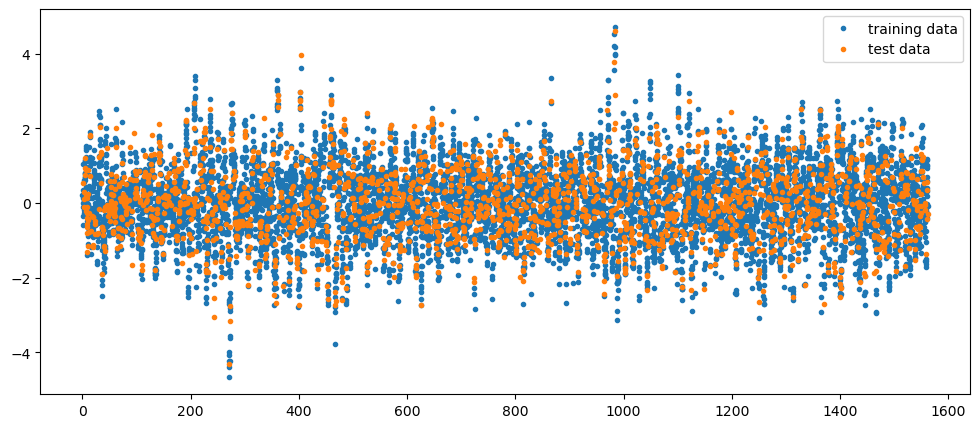

In [64]:
X_data = torch.from_numpy(X).unsqueeze(1)
y_data = torch.from_numpy(y).unsqueeze(1) 
y_data -= torch.mean(y_data)
y_std = torch.std(y_data)
if y_std > 0:     # guard against division by zero
    y_data = y_data / y_std

idx = torch.randperm(y_data.shape[0])[:8000]
# subset of the data
X_train = X_data[idx]
y_train = y_data[idx]


# mask for the "not chosen" indices
mask = torch.ones(y_data.shape[0], dtype=torch.bool)
mask[idx] = False

# the rest of the data
X_not = X_data[mask]
y_not = y_data[mask]

#all data
#X_train = X_data
#y_train = y_data


plt.figure(figsize=(12, 5))
plt.plot(X_train[:],y_train[:], '.', label='training data')
plt.plot(X_not[:],y_not[:], '.', label='test data')
plt.legend()
#plt.plot(X_data,y_data, label='all data')
print(f'number of datapoints: {y.shape[0]}')


In [65]:
## training preamble

kernels = ['SE', 'Laplace', 'RQ', 'LocPer']
methods = ['proj-sphere'] #projections
M_elbo = 500
M_proj = 500

times_vfe = []
out_vfe = []
times_proj = []
out_proj = []

#training setting
# for all 3300 points
n_steps = 2001
lr = 0.05
tol = 1e-3
optimizer = 'Adam'

In [66]:
## training routine



print('starting training ....')
for k in kernels:
    print(f'kernel = {k}')
    
    ##### Vanilla GP (NLL) #####
    # Not computed, too many datapoints
    
    
    ##### SparseGP (ELBO) ##### 
    
    gp_elbo = GP(X_train, y_train, kernel = k, M=M_elbo, method = 'VFE')
    out = gp_elbo.train_step(obj = 'elbo', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol, verbose = True)

    times_vfe.append(out["time"])     # save elapsed time
    
    gp_elbo.compute_moments()
    mu, _ = gp_elbo.forward(X_not)
    SE = torch.norm(mu-y_not)
    
    out_vfe.append(SE)
    
    
    for m in methods:
        print(f'projection method = {m}')
    
        ##### ProjGP ##### 
        gp_proj = GP(X_train, y_train, kernel = k, M=M_proj, method = m)
        out = gp_proj.train_step(obj = 'proj', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol, verbose = True)        

        times_proj.append(out["time"])     # save elapsed time
        
        gp_proj.compute_moments()
        mu, _ = gp_proj.forward(X_not)
        SE = torch.norm(mu-y_not)

        out_proj.append(SE)
        
print('Training complete')        

starting training ....
kernel = SE
NLL training ...
Using device: cpu
[init_Z_kmeanspp] KMeans finished in 1.036 seconds
Optimising elbo using Adam
Epoch 0: loss = 11627.8417
Epoch 200: loss = 8606.0140
Epoch 400: loss = 8601.0624
Early stop at iteration 452: loss did not improve for 5 steps.
Elapsed time: 148.1[s] with NLL = 7970.31
projection method = proj-sphere
Using device: cpu
Optimising proj using Adam
Epoch 0: loss = 693.8895
Early stop at iteration 197: loss did not improve for 5 steps.
Elapsed time: 306.2[s] with NLL = 6381.37
kernel = Laplace
NLL training ...
Using device: cpu
[init_Z_kmeanspp] KMeans finished in 1.182 seconds
Optimising elbo using Adam
Epoch 0: loss = 14191.3593
Epoch 200: loss = 11121.7857
Epoch 400: loss = 11122.0342
Epoch 600: loss = 11121.8803
Epoch 800: loss = 11122.0971
Epoch 1000: loss = 11122.0845
Epoch 1200: loss = 11122.1213
Epoch 1400: loss = 11121.9445
Epoch 1600: loss = 11122.0858
Epoch 1800: loss = 11122.0212
Epoch 2000: loss = 11122.0698
Elap

In [107]:
r_elbo = np.array([a.item() for a in out_vfe])
r_proj = np.array([a.item() for a in out_proj])
print(r_elbo)
print(r_proj) 

[24.76789427 23.37873809 23.99383692 24.15767778]
[19.79501321 17.11647163 19.71319597 18.52229262]


In [119]:
# Compute accuracy as relative squared error

NN = torch.mean(y_not**2)*y_not.shape[0] 
r_proj_scaled = [x**2 / NN  for x in r_proj]
r_elbo_scaled = [x**2 / NN  for x in r_elbo]

print(r_elbo_scaled)
print(r_proj_scaled)

[tensor(0.3035, dtype=torch.float64), tensor(0.2704, dtype=torch.float64), tensor(0.2848, dtype=torch.float64), tensor(0.2887, dtype=torch.float64)]
[tensor(0.1938, dtype=torch.float64), tensor(0.1449, dtype=torch.float64), tensor(0.1922, dtype=torch.float64), tensor(0.1697, dtype=torch.float64)]


In [124]:
def make_table_combined_noNLL(kernels, r_elbo, r_proj, times_vfe, times_proj, caption, label):
    """
    Build a LaTeX table with ELBO and PL results and their running times.

    Parameters
    ----------
    kernels : iterable of str
        Names of kernels (length n).
    r_elbo : iterable of float
        ELBO NLL values (length n).
    r_proj : iterable of float
        Projection (PL) NLL values (length n).
    times_vfe : iterable of float
        Running times for VFE/ELBO in seconds (length n).
    times_proj : iterable of float
        Running times for projection method in seconds (length n).
    caption : str
        Table caption.
    label : str
        Table label.
    """
    n = len(kernels)
    assert len(r_elbo) == n and len(r_proj) == n and len(times_vfe) == n and len(times_proj) == n, \
        "All input lists must have the same length."

    lines = []
    lines.append("\\begin{table}[ht]")
    lines.append("\\centering")
    lines.append("\\scriptsize")
    lines.append("\\begin{tabular}{lcccc}")
    lines.append("\\toprule")
    # grouped headers
    lines.append("Kernel & \\multicolumn{2}{c}{VFE} & \\multicolumn{2}{c}{PL} \\\\")
    lines.append("\\cmidrule(lr){2-3} \\cmidrule(lr){4-5}")
    lines.append(" & RMSE & Time (s) & RMSE & Time (s) \\\\")
    lines.append("\\midrule")

    for i, k in enumerate(kernels):
        elbo_val = float(r_elbo[i])
        time_vfe = float(times_vfe[i])
        proj_val = float(r_proj[i])
        time_proj = float(times_proj[i])
        row = f"{k} & {elbo_val:.3f} & {time_vfe:.2f} & {proj_val:.3f} & {time_proj:.2f} \\\\"
        lines.append(row)

    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")
    lines.append(f"\\caption{{{caption}}}")
    lines.append(f"\\label{{{label}}}")
    lines.append("\\end{table}")

    return "\n".join(lines)


In [125]:
print(make_table_combined_noNLL(kernels, r_elbo_scaled, r_proj_scaled, times_vfe, times_proj, "EEG: Performance and running time", "tab:eeg"))


\begin{table}[ht]
\centering
\scriptsize
\begin{tabular}{lcccc}
\toprule
Kernel & \multicolumn{2}{c}{VFE} & \multicolumn{2}{c}{PL} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5}
 & RMSE & Time (s) & RMSE & Time (s) \\
\midrule
SE & 0.303 & 148.08 & 0.194 & 306.22 \\
Laplace & 0.270 & 614.32 & 0.145 & 630.61 \\
RQ & 0.285 & 402.32 & 0.192 & 337.68 \\
LocPer & 0.289 & 611.61 & 0.170 & 554.79 \\
\bottomrule
\end{tabular}
\caption{EEG: Performance and running time}
\label{tab:eeg}
\end{table}


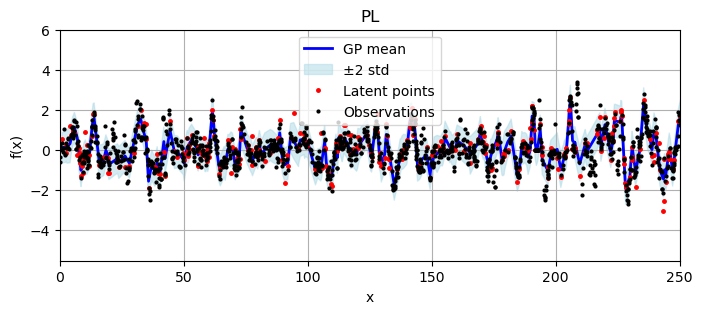

In [126]:
#proj
gp_proj.compute_moments()
mu,var = gp_proj.forward(X_not)
SE = torch.norm(mu-y_not)
ax = plot_gp(X_not, mu, var, X_obs=X_train, y_obs=y_train, X_latent=X_not, y_latent=y_not,
             title = f"PL", 
            xlim1 = 0, xlim2 = 250)



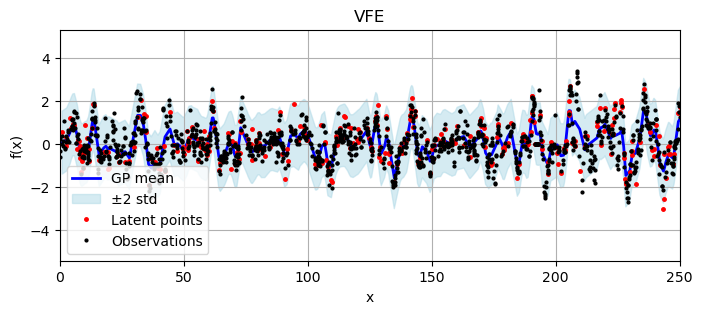

In [127]:
#elbo
gp_elbo.compute_moments()
mu,var = gp_elbo.forward(X_not)
SE = torch.norm(mu-y_not)
ax = plot_gp(X_not, mu, var, X_obs=X_train, y_obs=y_train, X_latent=X_not, y_latent=y_not,
             title = "VFE", 
            xlim1 = 0, xlim2 = 250)


#### 